# Importing Library

In [24]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6
import pandas as pd


import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARMA, ARIMA
#from pyramid.arima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
#from fbprophet import Prophet

from math import sqrt

import matplotlib
#matplotlib.rcParams['axes.labelsize'] = 14
#matplotlib.rcParams['xtick.labelsize'] = 12
#matplotlib.rcParams['ytick.labelsize'] = 12
#matplotlib.rcParams['text.color'] = 'k'
import seaborn as sns

from random import random

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error, mean_squared_log_error

# Importing Data

Loading data of Gold and Silver on Monthly Basis from Investing.com. Data worth of past 10 years (start date:03/05/2010, end date: 03/05/2020),

In [25]:
#Loading data of Gold and Silver on Monthly Basis

headers = ['Date', 'Price', 'Open', 'High', 'Low', 'Vol.', 'Change%'] 
parse_dates = ['Date']

gold = pd.read_csv('C:/Users/Prachi Gopalani/Desktop/New folder (6)/fore/Gold Futures Historical Data (1).csv'
                   , parse_dates=parse_dates,encoding ='utf-8')
gold.columns= headers

silver = pd.read_csv('C:/Users/Prachi Gopalani/Desktop/New folder (6)/Silver Futures Historical Data (1).csv',
                     parse_dates=parse_dates,encoding ='utf-8')
silver.columns= headers

In [26]:
print ("Gold commodity has {} observations & {} features".format(*gold.shape))
print ("Silver commodity has {} observations & {} features".format(*silver.shape))

Gold commodity has 121 observations & 7 features
Silver commodity has 730 observations & 7 features


Creating a new dataframe having (only Date and Price of Gold futures)

In [27]:
# Create the pandas DataFrame 
df = pd.DataFrame(gold, columns = ['Date', 'Price'])
df.head()

,Date,Price
0,May 20,"1,700.90"
1,Apr 20,"1,694.20"
2,Mar 20,"1,592.10"
3,Feb 20,"1,566.70"
4,Jan 20,"1,587.90"


In [28]:
df.head(2)

,Date,Price
0,May 20,"1,700.90"
1,Apr 20,"1,694.20"


In [29]:
df.describe()

,Date,Price
count,121,121
unique,121,120
top,Oct 18,"1,316.20"
freq,1,2


In [30]:
df.describe()

,Date,Price
count,121,121
unique,121,120
top,Oct 18,"1,316.20"
freq,1,2


In [31]:
from IPython.display import display
display(df[:10].T)

,0,1,2,3,4,5,6,7,8,9
Date,May 20,Apr 20,Mar 20,Feb 20,Jan 20,Dec 19,Nov 19,Oct 19,Sep 19,Aug 19
Price,"1,700.90","1,694.20","1,592.10","1,566.70","1,587.90","1,519.50","1,465.60","1,511.40","1,465.70","1,519.10"


# Data Preprocessing and Visualization 

#### Converting to datetime format:



In [32]:
df['Date'] = pd.to_datetime(df['Date'], format='%b %y')

#### Setting index as the datetime column for easier manipulations:

In [33]:
y = df.set_index('Date')

In [34]:
y.index

DatetimeIndex(['2020-05-01', '2020-04-01', '2020-03-01', '2020-02-01',
               '2020-01-01', '2019-12-01', '2019-11-01', '2019-10-01',
               '2019-09-01', '2019-08-01',
               ...
               '2011-02-01', '2011-01-01', '2010-12-01', '2010-11-01',
               '2010-10-01', '2010-09-01', '2010-08-01', '2010-07-01',
               '2010-06-01', '2010-05-01'],
              dtype='datetime64[ns]', name='Date', length=121, freq=None)

In [35]:
y.isnull().sum()

Price    0
dtype: int64

# Non-Stationary time series of Gold

In [36]:
stationary_check_gold = df.set_index(['Date'])
#stationary_check_silver = silver.set_index(['Date'])
stationary_check_gold_price = stationary_check_gold['Price'].str.replace(',', '').astype(float)
#stationary_check_silver_price = stationary_check_silver['Price']

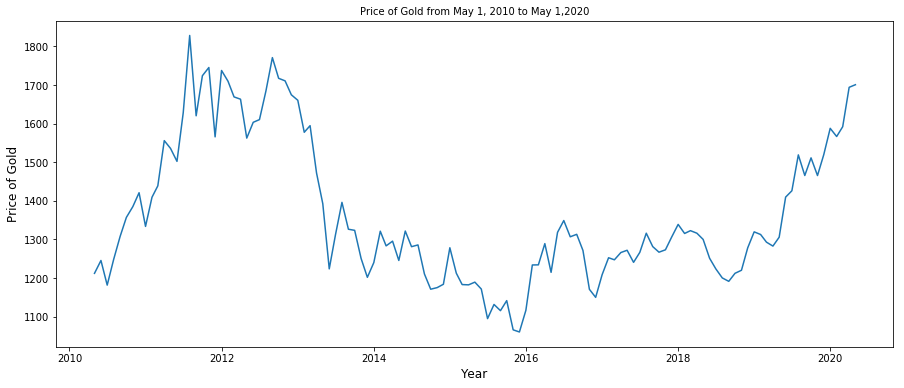

In [37]:
plt.plot(stationary_check_gold_price)
plt.ylabel('Price of Gold', fontsize=12)
plt.xlabel('Year', fontsize=12)
plt.title('Price of Gold from May 1, 2010 to May 1,2020', fontsize=10)
plt.show()

#### Reviewing plots of the density of observations can provide further insight into the structure of the data:

The distribution is not perfectly Gaussian (normal distribution).                                                               
The distribution is left shifted.                                                                                               
Transformations might be useful prior to modelling.                                                                             

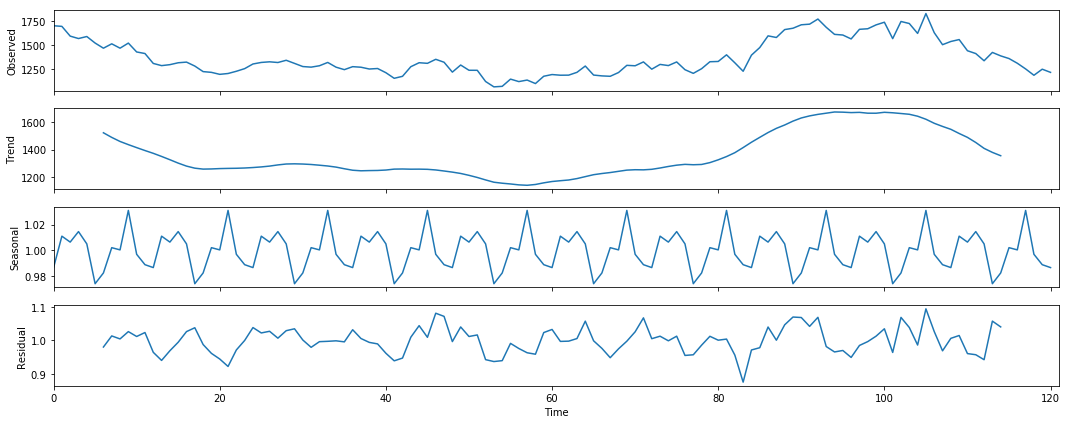

In [38]:
import statsmodels.api as sm
# multiplicative
res = sm.tsa.seasonal_decompose(stationary_check_gold_price.values,freq=12,model="multiplicative")
fig = res.plot()

# Box and Whisker Plots:

Median values across years confirms an upwards trend.                                                                           
Steady increase in the spread, or middle 50% of the data (boxes) over time

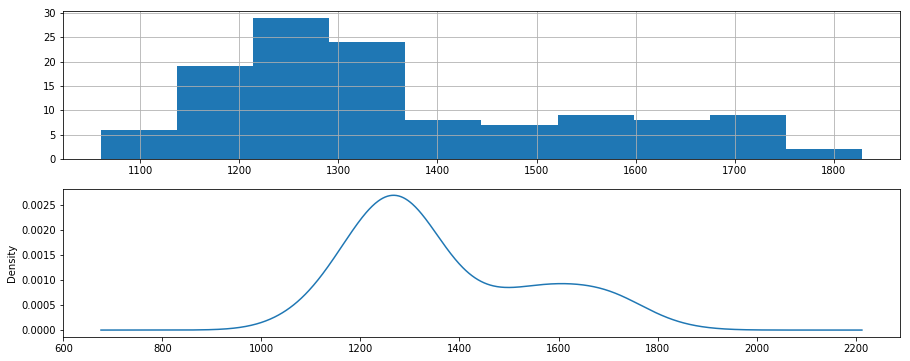

In [39]:
from pandas import Series
from matplotlib import pyplot
pyplot.figure(1)
pyplot.subplot(211)
stationary_check_gold_price.hist()
pyplot.subplot(212)
stationary_check_gold_price.plot(kind='kde')
pyplot.show()

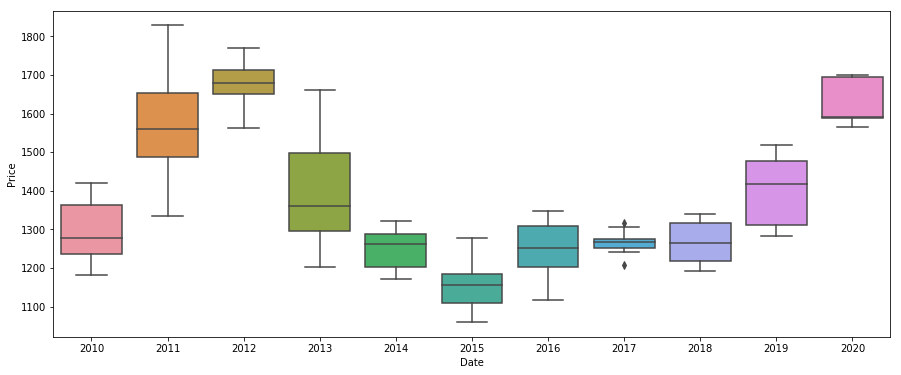

In [40]:
fig, ax = plt.subplots(figsize=(15,6))
sns.boxplot(stationary_check_gold_price.index.year, stationary_check_gold_price, ax=ax)

### Decomposing using statsmodel:

The decomposition of time series shows a statistical task that deconstructs a time series into several components, each representing one of the underlying categories of patterns.                                                                     
With statsmodels we are be able to see the trend, seasonal, and residual components of our data.

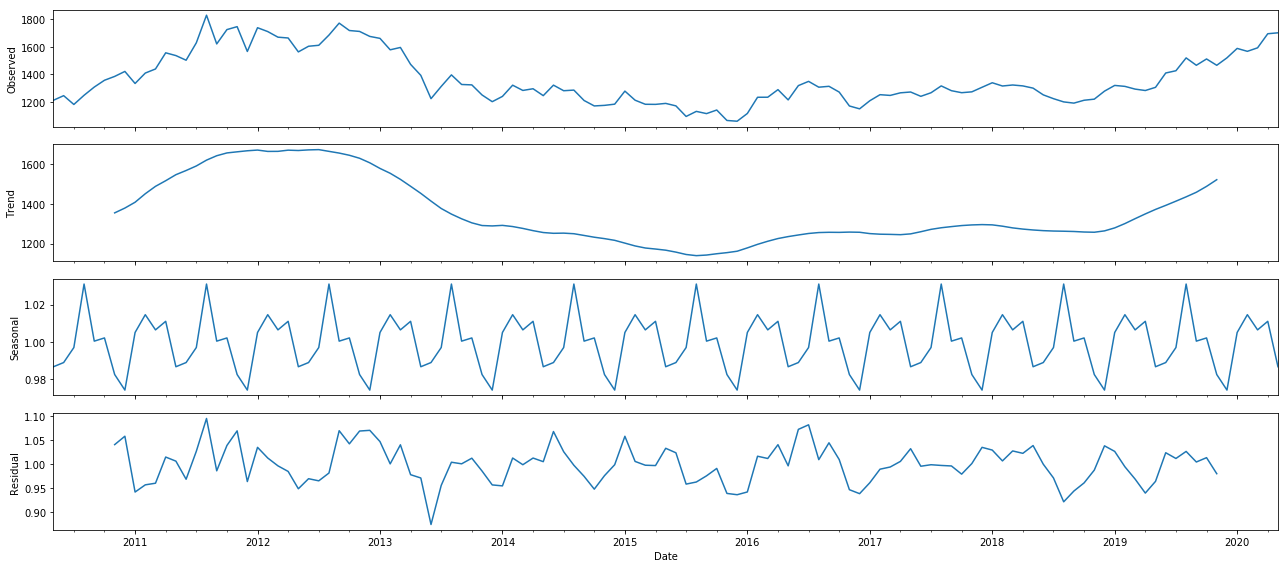

In [41]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(stationary_check_gold_price, model='multiplicative')
fig = decomposition.plot()
plt.show()

# Stationarity

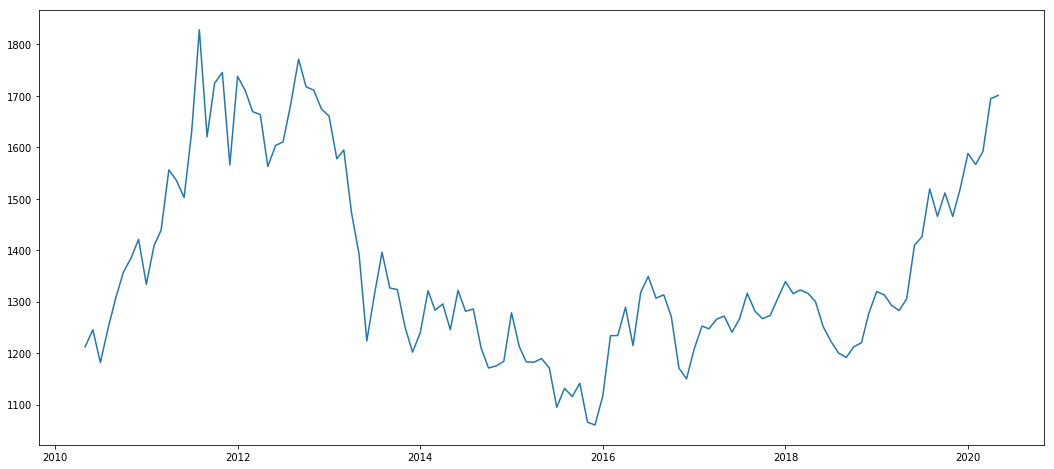

In [42]:
plt.plot(stationary_check_gold_price)

# Checking stationarity

We can check stationarity using the following:                                                                                 
1.ACF and PACF plots                                                                                                           
2.Plotting Rolling Statistics                                                                                                   
3.Augmented Dickey-Fuller Test

### ACF and PACF plots

Let's review the Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) plots

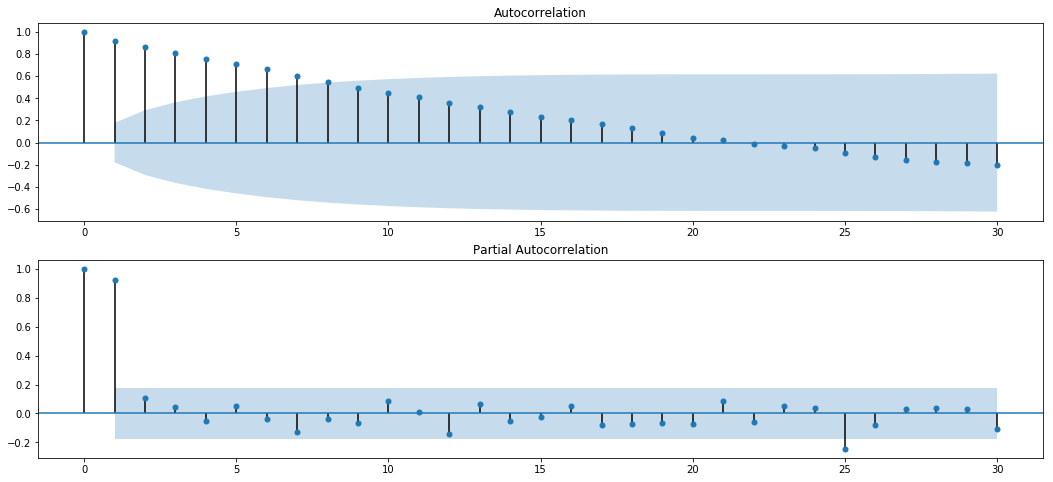

In [43]:
#Importing ACF and PACF Libraray
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

pyplot.figure()
pyplot.subplot(211)
plot_acf(stationary_check_gold_price, ax=pyplot.gca(), lags = 30)
pyplot.subplot(212)
plot_pacf(stationary_check_gold_price, ax=pyplot.gca(), lags = 30)
pyplot.show()

This data is non-stationary as a high number of previous observations are correlated with future values.                          
Confidence intervals are drawn as a cone.                                                                                       
By default, this is set to a 95% confidence interval, suggesting that correlation values outside of this code are very likely a correlation and not a statistical fluke.
The partial autocorrelation at lag k is the correlation that results after removing the effect of any correlations due to the terms at shorter lags.

### Plotting Rolling Statistics

We observe that the rolling mean and Standard deviation are not constant with respect to time (increasing trend)                
The time series is hence not stationary

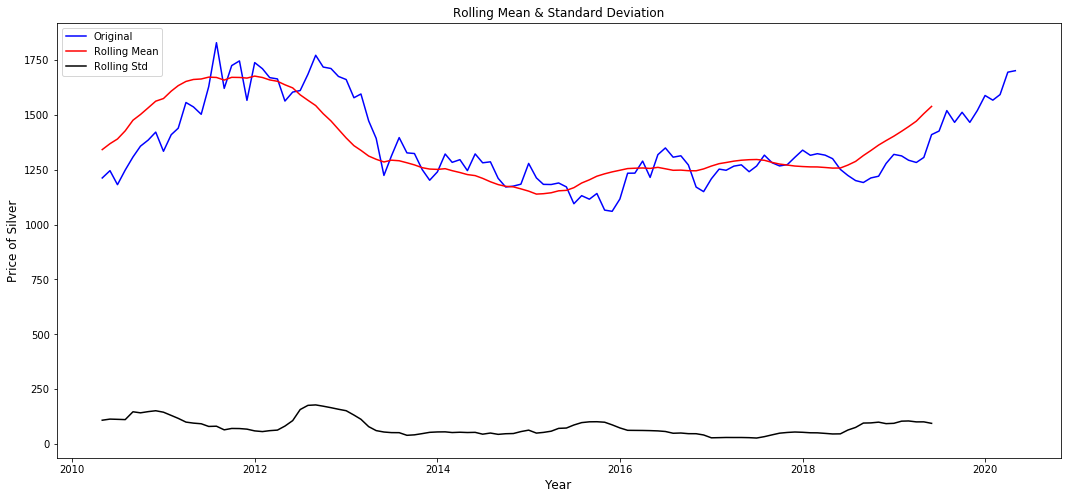

Results of Dickey-Fuller Test:
Test Statistic                  -2.318523
p-value                          0.166064
#Lags Used                       0.000000
Number of Observations Used    120.000000
Critical Value (1%)             -3.486056
Critical Value (5%)             -2.885943
Critical Value (10%)            -2.579785
dtype: float64


In [44]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries, commodity):
    
    #Determing rolling statistics
    #rolmean = pd.rolling_mean(timeseries, window=12)
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()

    #rolstd = pd.rolling_std(timeseries, window=12)

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.ylabel('Price of {}'.format(commodity), fontsize=12)
    plt.xlabel('Year', fontsize=12)
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print( 'Results of Dickey-Fuller Test:' )
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

test_stationarity(stationary_check_gold_price, 'Silver')

### Augmented Dickey-Fuller Test

Null hypothesis: The time series is not stationary                                                                             
Rejecting the null hypothesis (i.e. a very low p-value) will indicate staionarity

In [45]:
from statsmodels.tsa.stattools import adfuller

In [46]:
#Perform Dickey-Fuller test:
print ('Results of Dickey-Fuller Test:')
dftest = adfuller(stationary_check_gold_price, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print (dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                  -2.318523
p-value                          0.166064
#Lags Used                       0.000000
Number of Observations Used    120.000000
Critical Value (1%)             -3.486056
Critical Value (5%)             -2.885943
Critical Value (10%)            -2.579785
dtype: float64


Though the variation in standard deviation is small, mean is clearly varying with time and this is not a stationary series. Also, the test statistic higher than the critical values, meaning we are much less likely to reject the null hypothesis (it looks non-stationary).

In [47]:
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

# Making Time Series Stationary

# Transformations

We can apply transformation which penalize higher values more than smaller values. These can be taking a log, square root, cube root, etc. Lets take a log transform here for simplicity:


### Log Scale Transformation

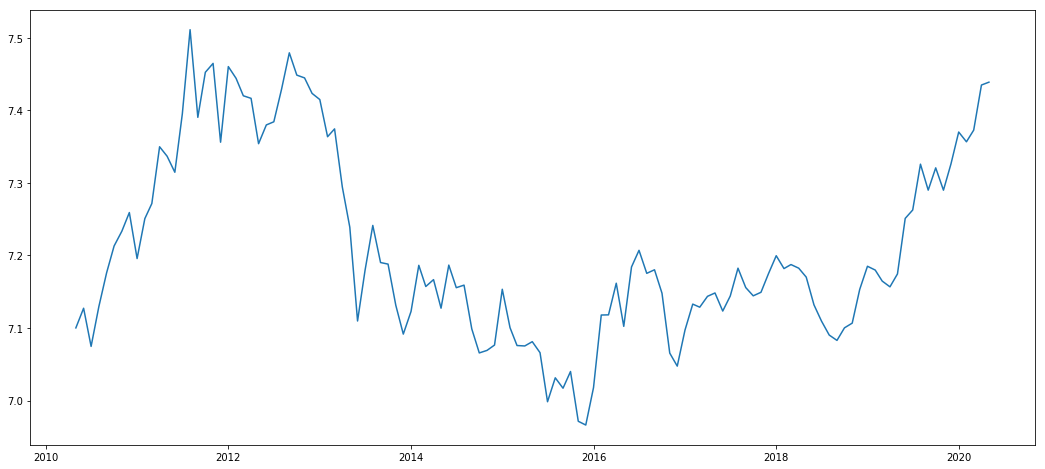

In [48]:
ts_log = np.log(stationary_check_gold_price)
plt.plot(ts_log)

## Techniques to remove Trend - Smoothing


### Moving Average

Make It Stationary Mehtod 1 - Moving Average [Eliminate Trend Only]

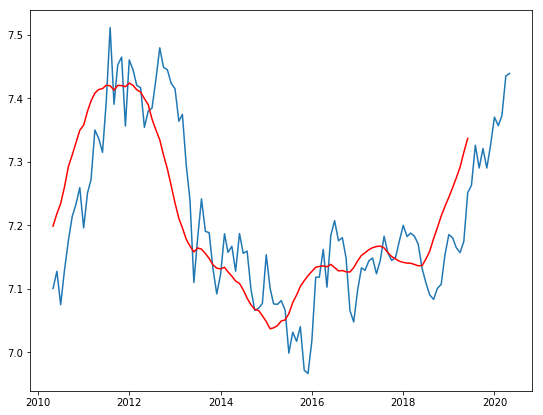

In [49]:
moving_avg = ts_log.rolling(window=12,center=False).mean()  # taking average of LAST 2 years (36-12) values
plt.figure(figsize=(9,7))
plt.plot(ts_log)
plt.plot(moving_avg, color='red')
plt.show()

In [50]:
ts_log_moving_avg_diff = ts_log - moving_avg
ts_log_moving_avg_diff.head(12)   # rolling mean is not defined in the first 12 values, it's YEARLY average

Date
2020-05-01         NaN
2020-04-01         NaN
2020-03-01         NaN
2020-02-01         NaN
2020-01-01         NaN
2019-12-01         NaN
2019-11-01         NaN
2019-10-01         NaN
2019-09-01         NaN
2019-08-01         NaN
2019-07-01         NaN
2019-06-01   -0.085561
Name: Price, dtype: float64

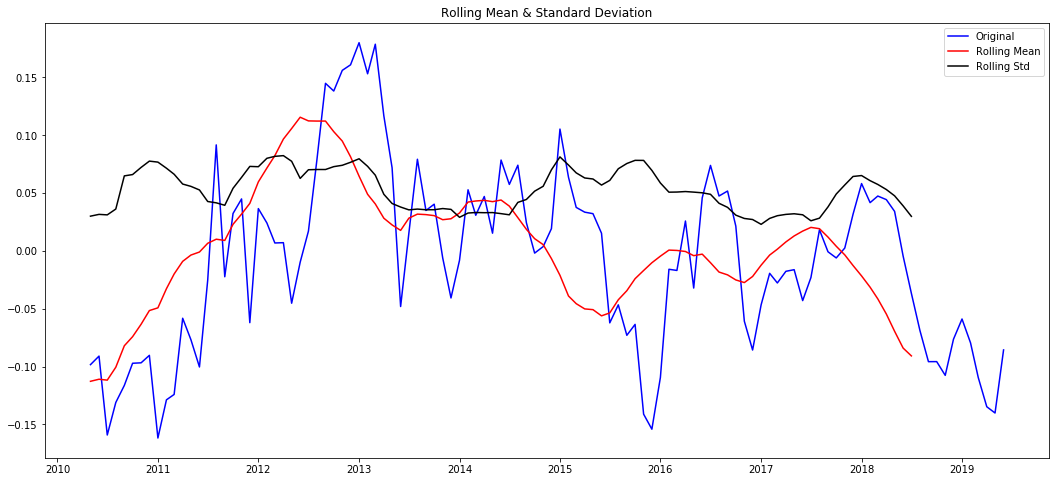

Results of Dickey-Fuller Test:
Test Statistic                  -3.006000
p-value                          0.034338
#Lags Used                       0.000000
Number of Observations Used    109.000000
Critical Value (1%)             -3.491818
Critical Value (5%)             -2.888444
Critical Value (10%)            -2.581120
dtype: float64


In [51]:
ts_log_moving_avg_diff.dropna(inplace=True)
test_stationarity(ts_log_moving_avg_diff)

## Weighted Moving Average

Make It Stationary Mehtod 2 - Weighted Moving Average [Eliminate Trend Only]

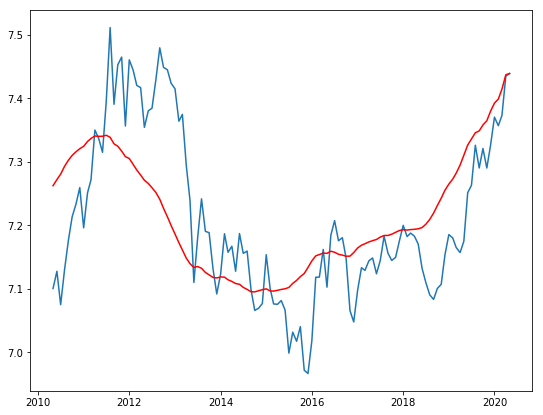

In [52]:
expwighted_avg = ts_log.ewm(halflife=12,ignore_na=False,min_periods=0,adjust=True).mean()
plt.figure(figsize=(9,7))
plt.plot(ts_log)
plt.plot(expwighted_avg, color='red')
plt.show()

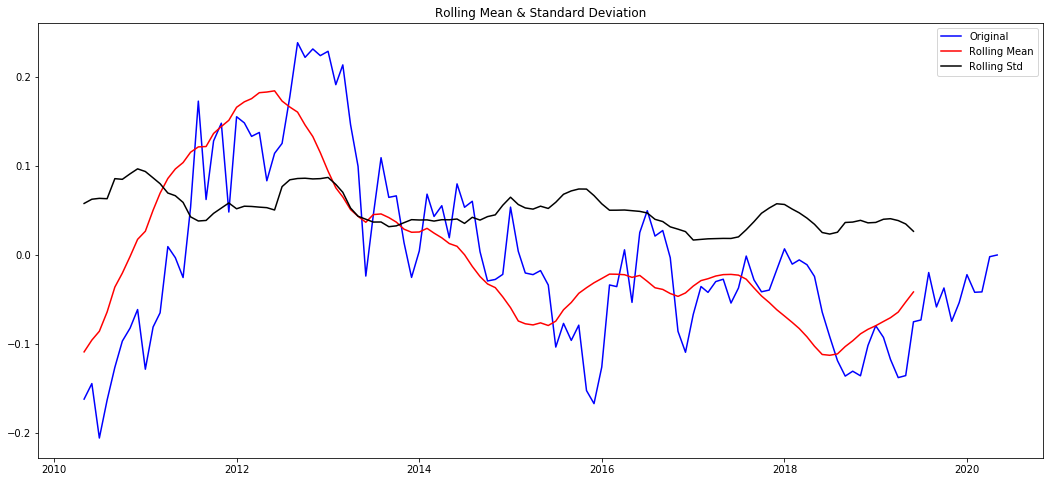

Results of Dickey-Fuller Test:
Test Statistic                  -2.195213
p-value                          0.207988
#Lags Used                       0.000000
Number of Observations Used    120.000000
Critical Value (1%)             -3.486056
Critical Value (5%)             -2.885943
Critical Value (10%)            -2.579785
dtype: float64


In [53]:
ts_log_ewma_diff = ts_log - expwighted_avg
test_stationarity(ts_log_ewma_diff)

#### Make It Stationary Method 3 [Eliminating Trend and Seasonality]                                                                 


Differencing – taking the differece with a particular time lag

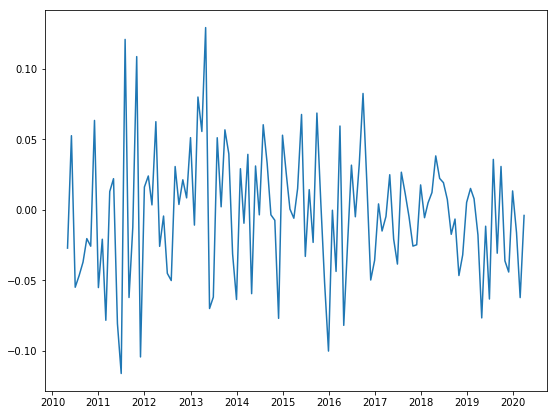

In [54]:
ts_log_diff = ts_log - ts_log.shift()
plt.figure(figsize=(9,7))
plt.plot(ts_log_diff)
plt.show()

In [55]:
ts_log_diff.head()

Date
2020-05-01         NaN
2020-04-01   -0.003947
2020-03-01   -0.062157
2020-02-01   -0.016082
2020-01-01    0.013441
Name: Price, dtype: float64

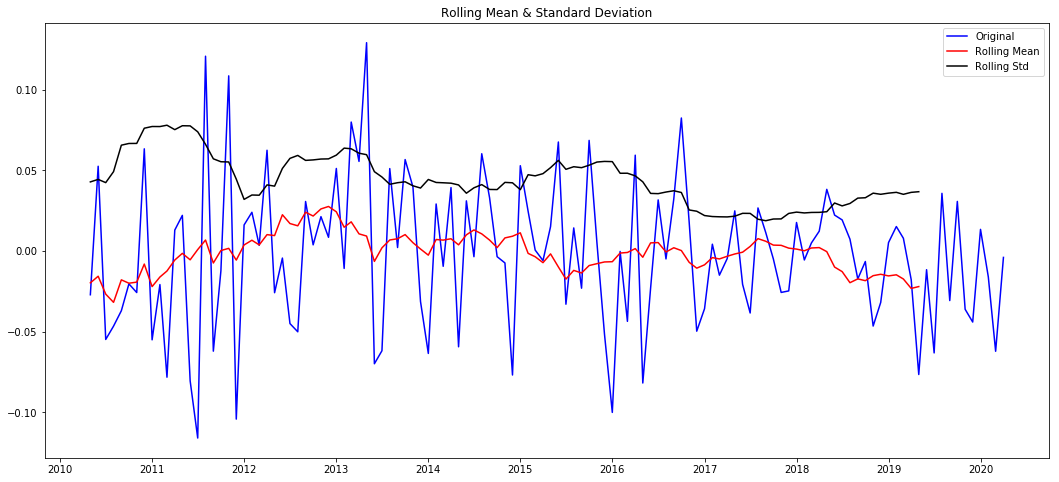

Results of Dickey-Fuller Test:
Test Statistic                -1.210773e+01
p-value                        1.951284e-22
#Lags Used                     0.000000e+00
Number of Observations Used    1.190000e+02
Critical Value (1%)           -3.486535e+00
Critical Value (5%)           -2.886151e+00
Critical Value (10%)          -2.579896e+00
dtype: float64


In [56]:
ts_log_diff.dropna(inplace=True)
test_stationarity(ts_log_diff)

# It's better than the above 2 methods (for this case), basde on the plot
# Although Test Statistics is still higher than all the  Critical Value, it's closer

#### Make It Stationary Method 4 [Eliminating Trend and Seasonality]

Decoposing - trend and seasonality are modeled separately and the remaining part of the series is returned

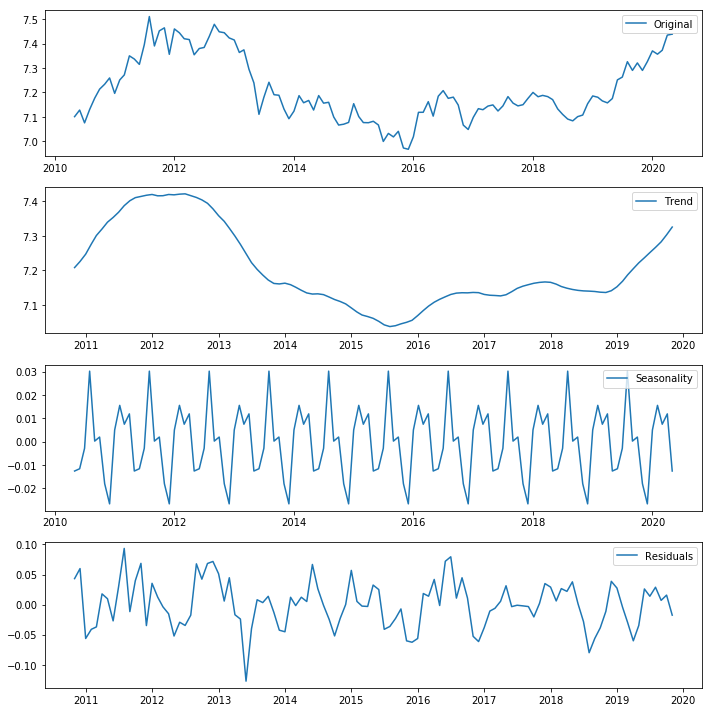

In [57]:
from statsmodels.tsa.seasonal import seasonal_decompose

# trend, seasonality are separated out from data, and we can model the residuals
decomposition = seasonal_decompose(ts_log)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(10,10))
plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

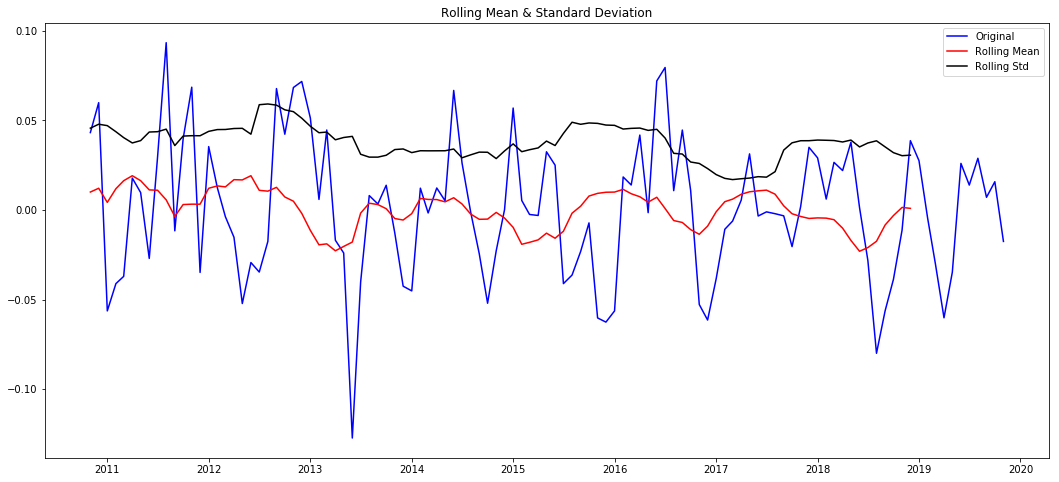

Results of Dickey-Fuller Test:
Test Statistic                 -3.162724
p-value                         0.022246
#Lags Used                     12.000000
Number of Observations Used    96.000000
Critical Value (1%)            -3.500379
Critical Value (5%)            -2.892152
Critical Value (10%)           -2.583100
dtype: float64


In [58]:
ts_log_decompose = residual
ts_log_decompose.dropna(inplace=True)
test_stationarity(ts_log_decompose)

### ARIMA Model 

                             ARIMA Model Results                              
Dep. Variable:                D.Price   No. Observations:                  120
Model:                 ARIMA(5, 1, 0)   Log Likelihood                -669.184
Method:                       css-mle   S.D. of innovations             63.894
Date:                Sun, 03 May 2020   AIC                           1352.369
Time:                        14:35:56   BIC                           1371.881
Sample:                    04-01-2020   HQIC                          1360.293
                         - 05-01-2010                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -4.1389      5.173     -0.800      0.425     -14.277       6.000
ar.L1.D.Price    -0.1470      0.091     -1.619      0.108      -0.325       0.031
ar.L2.D.Price    -0.0416      0.092     

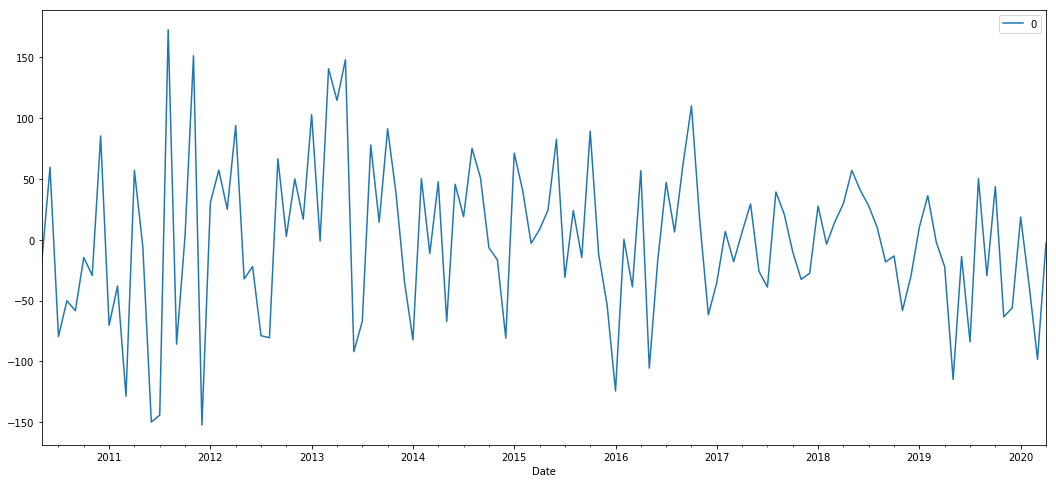

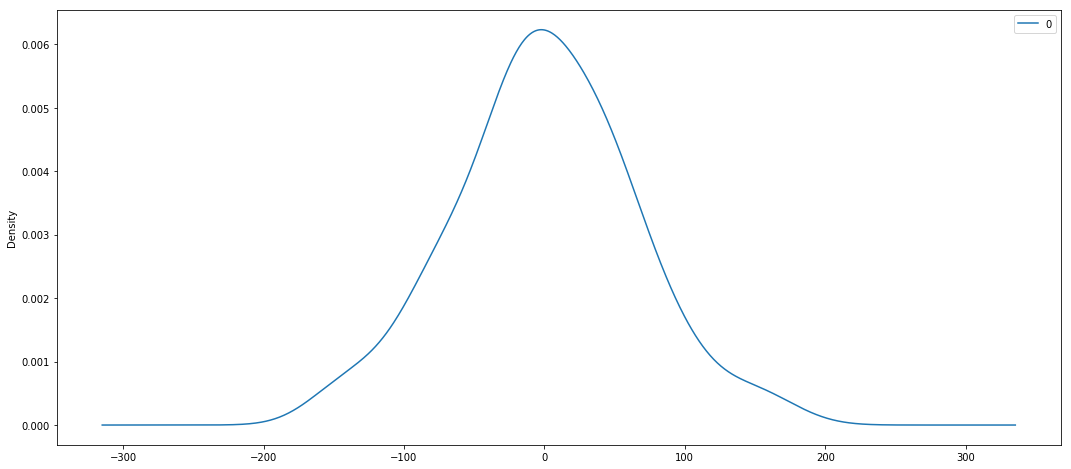

                0
count  120.000000
mean     0.050507
std     64.175330
min   -152.300139
25%    -35.610297
50%     -1.403176
75%     41.511526
max    172.805605


In [59]:
from pandas import DataFrame

# fit model
model = ARIMA(stationary_check_gold_price, order=(5,1,0))
model_fit = model.fit(disp=0)  # with disp=0, we are turning off the debug info about fitting the linear regression
print(model_fit.summary())

# plot residual errors
residuals = DataFrame(model_fit.resid)
residuals.plot()
pyplot.show()
residuals.plot(kind='kde')
pyplot.show()
print(residuals.describe())

In [60]:
stationary_check_gold_price.values

array([1700.9, 1694.2, 1592.1, 1566.7, 1587.9, 1519.5, 1465.6, 1511.4,
       1465.7, 1519.1, 1426.1, 1409.7, 1305.8, 1282.8, 1293. , 1312.8,
       1319.7, 1278.3, 1220.2, 1212.3, 1191.5, 1200.3, 1223.7, 1251.3,
       1300.1, 1316.2, 1322.8, 1315.5, 1339. , 1306.3, 1273.2, 1267. ,
       1281.5, 1316.2, 1266.6, 1240.7, 1272. , 1266.1, 1247.3, 1252.6,
       1208.6, 1150. , 1170.8, 1271.5, 1313.3, 1306.9, 1349. , 1318.4,
       1214.8, 1289.2, 1234.2, 1233.9, 1116.4, 1060.3, 1065.8, 1141.5,
       1115.5, 1131.6, 1094.9, 1171.5, 1189.4, 1182.4, 1183.1, 1212.6,
       1278.5, 1183.9, 1175.2, 1171.1, 1210.5, 1285.8, 1281.3, 1321.8,
       1245.6, 1295.6, 1283.4, 1321.4, 1240.1, 1201.9, 1250.6, 1323.6,
       1326.5, 1396.1, 1312.4, 1223.8, 1392.6, 1472.2, 1594.8, 1577.7,
       1660.6, 1674.8, 1710.9, 1717.5, 1771.1, 1684.6, 1610.5, 1603.5,
       1562.6, 1663.4, 1669.3, 1709.9, 1737.8, 1565.8, 1745.5, 1724.2,
       1620.4, 1828.5, 1628.3, 1502.3, 1535.9, 1556. , 1438.9, 1409.3,
      

predicted=1203.436568, expected=1392.600000
predicted=1389.395682, expected=1472.200000
predicted=1469.327759, expected=1594.800000
predicted=1546.236536, expected=1577.700000
predicted=1550.367965, expected=1660.600000
predicted=1662.747757, expected=1674.800000
predicted=1701.082200, expected=1710.900000
predicted=1711.884095, expected=1717.500000
predicted=1722.901244, expected=1771.100000
predicted=1778.661923, expected=1684.600000
predicted=1690.241421, expected=1610.500000
predicted=1595.853876, expected=1603.500000
predicted=1617.370683, expected=1562.600000
predicted=1567.944853, expected=1663.400000
predicted=1651.895959, expected=1669.300000
predicted=1676.495225, expected=1709.900000
predicted=1691.508783, expected=1737.800000
predicted=1740.793165, expected=1565.800000
predicted=1569.510850, expected=1745.500000
predicted=1708.215939, expected=1724.200000
predicted=1771.046946, expected=1620.400000
predicted=1629.537974, expected=1828.500000
predicted=1747.055995, expected=

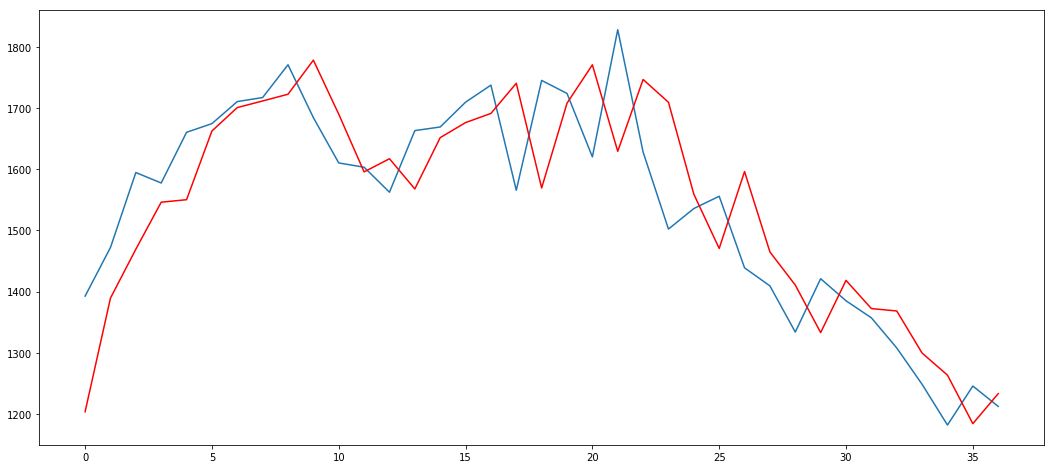

In [61]:
from sklearn.metrics import mean_squared_error

X = stationary_check_gold_price.values
size = int(len(X) * 0.7)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()

for t in range(len(test)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    y_pred = output[0]
    predictions.append(y_pred)
    obs = test[t]
    history.append(obs)  # The observation value in the last run will be put as the history for the next run
    print('predicted=%f, expected=%f' % (y_pred, obs))  # compare each prediction and observation
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)

# plot the forecast
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()

#### try ARIMA model on differenting output, since it gave best result above

In [62]:
from statsmodels.tsa.stattools import acf, pacf

lag_acf = acf(ts_log_diff, nlags=20)
lag_pacf = pacf(ts_log_diff, nlags=20, method='ols')

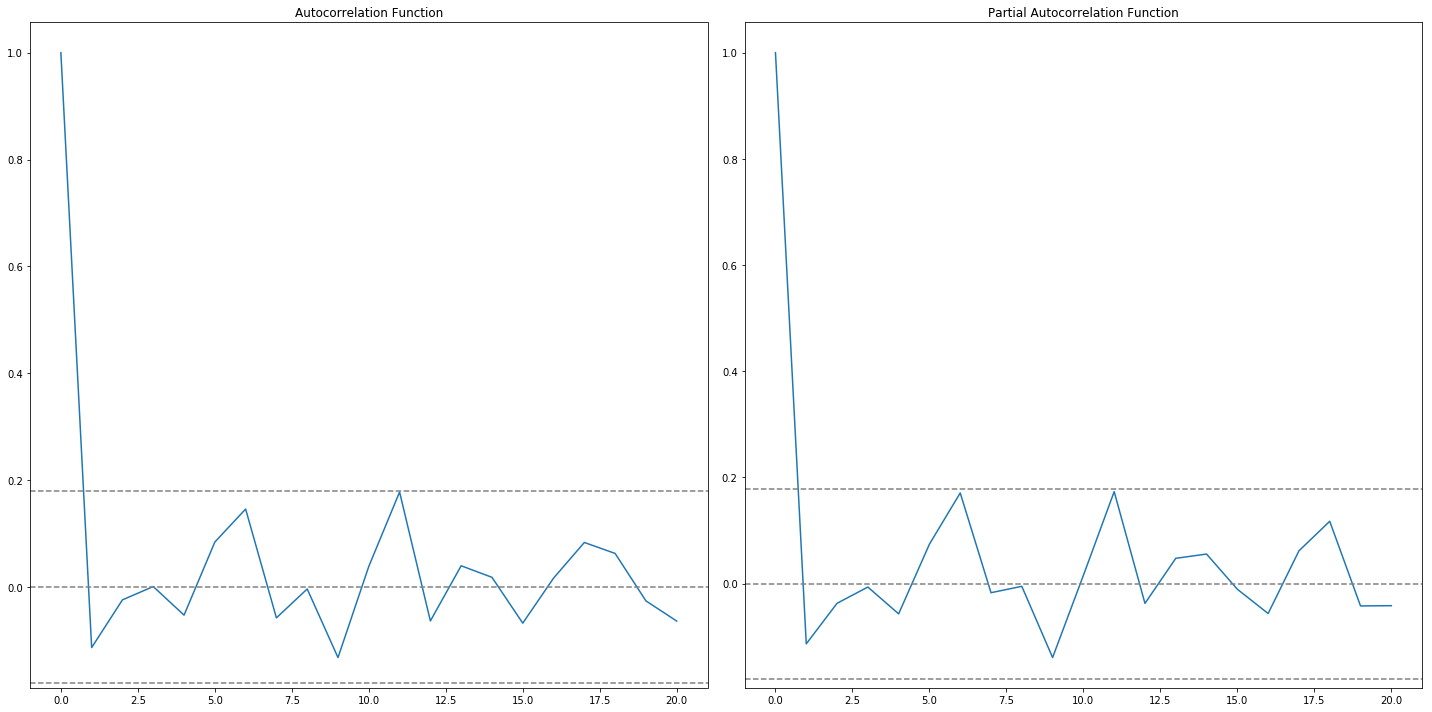

In [63]:
plt.figure(figsize=(20,10))

#Plot ACF: 
## q – The lag value where the ACF chart crosses the upper confidence interval for the first time (in this case q=1)
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

#Plot PACF:
## p – The lag value where the PACF chart crosses the upper confidence interval for the first time (in this case p=1)
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()
plt.show()

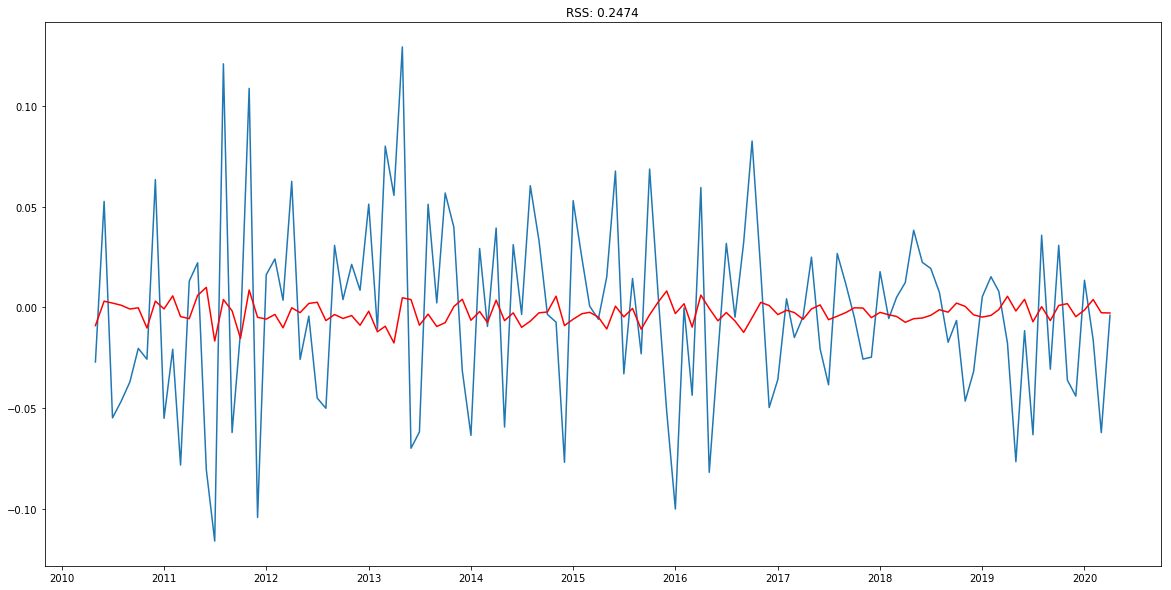

In [64]:
from statsmodels.tsa.arima_model import ARIMA
# RSS is for the values of residuals

# AR model
model = ARIMA(ts_log, order=(1, 1, 0))  
results_AR = model.fit(disp=-1) 
plt.figure(figsize=(20,10))
plt.plot(ts_log_diff)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-ts_log_diff)**2))
plt.show()

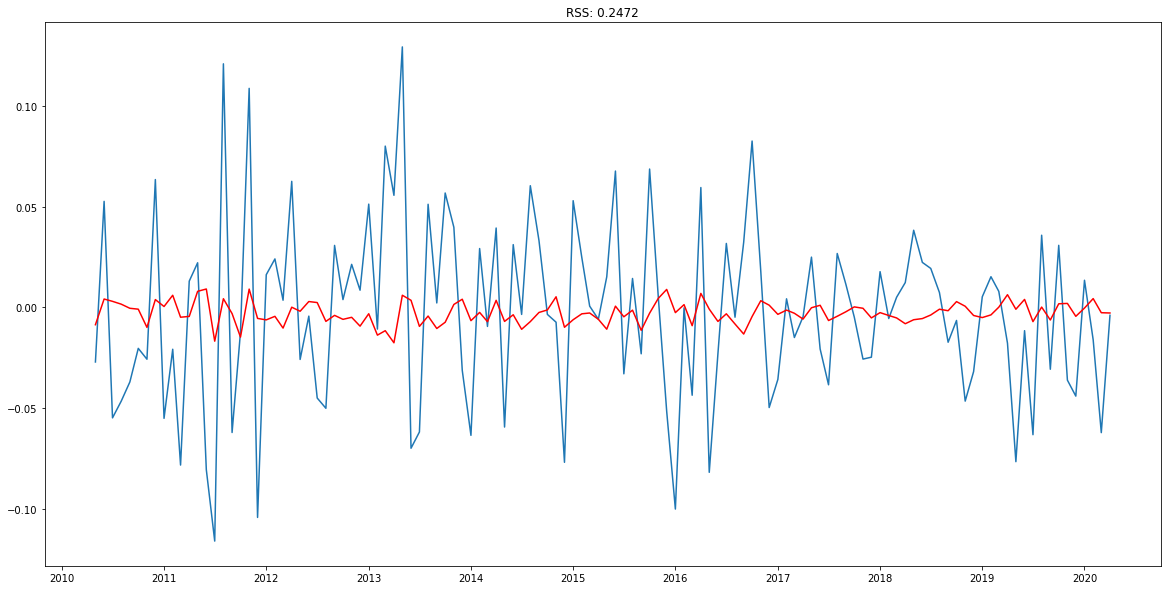

In [65]:
# MA Model

model = ARIMA(ts_log, order=(0, 1, 1))  
results_MA = model.fit(disp=-1)  
plt.figure(figsize=(20,10))
plt.plot(ts_log_diff)
plt.plot(results_MA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_MA.fittedvalues-ts_log_diff)**2))
plt.show()

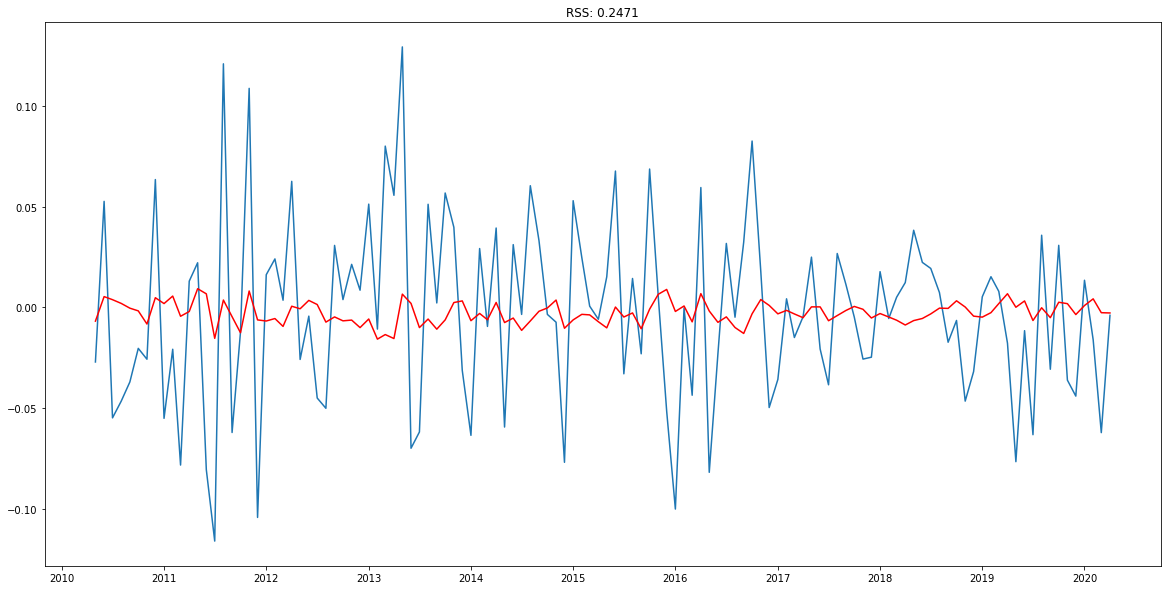

In [66]:
# combined mobel

model = ARIMA(ts_log, order=(1, 1, 1))  
results_ARIMA = model.fit(disp=-1)  
plt.figure(figsize=(20,10))
plt.plot(ts_log_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-ts_log_diff)**2))
plt.show()

In [67]:

# As we can see based on RSS (sum of resuduals)
## Scale back to original value, and see how this combined value performs

# Step 1 - store predicted result as seperated result
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
print (predictions_ARIMA_diff.head())

# start with 1901-02-01 is because we took the lag by 1, first element has nothing to subtract

Date
2020-04-01   -0.002781
2020-03-01   -0.002649
2020-02-01    0.004219
2020-01-01    0.000906
2019-12-01   -0.003571
dtype: float64


In [68]:

# Step 2 - Convert the differencing to log scale
## Add these differences consecutively to the base number
## An easy way to do it is to first determine the cumulative sum at index and then add it to the base number

predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
print (predictions_ARIMA_diff_cumsum.head())

Date
2020-04-01   -0.002781
2020-03-01   -0.005431
2020-02-01   -0.001212
2020-01-01   -0.000306
2019-12-01   -0.003877
dtype: float64


In [69]:
predictions_ARIMA_log = pd.Series(ts_log.iloc[0], index=ts_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA_log.head()

Date
2010-05-01    7.103587
2010-06-01    7.110417
2010-07-01    7.105078
2010-08-01    7.101270
2010-09-01    7.099304
dtype: float64

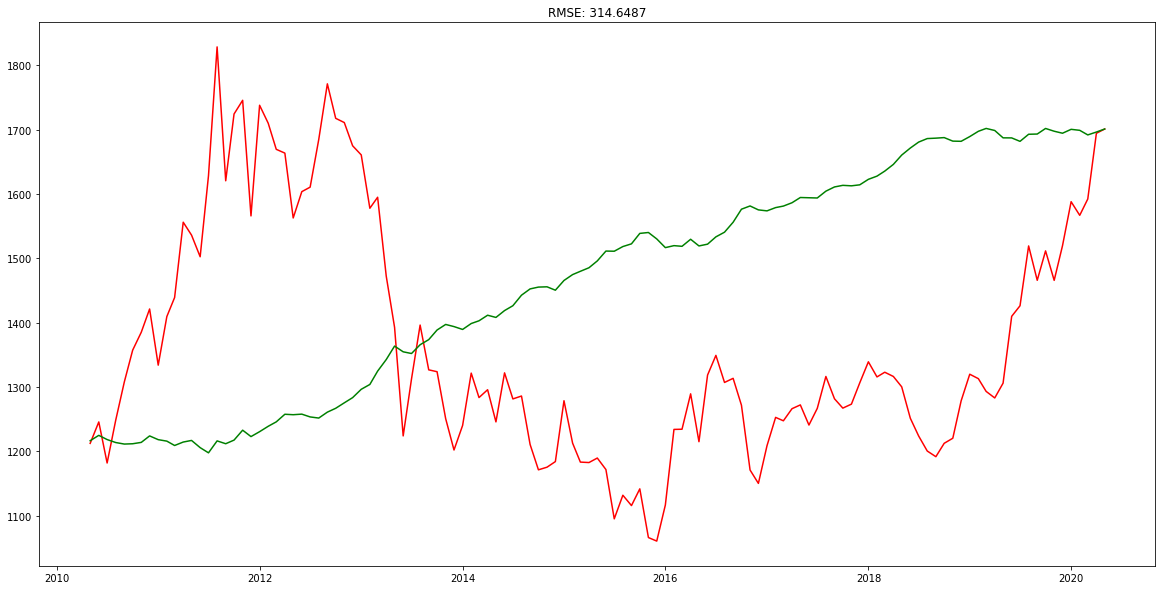

In [70]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.figure(figsize=(20,10))
plt.plot(stationary_check_gold_price, color='red')
plt.plot(predictions_ARIMA, color='green')
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-stationary_check_gold_price)**2)/len(stationary_check_gold_price)))
plt.show()

In [71]:
# The forecast result is not really good.... Maybe the training data needs more years